# DBTL1: ART recommendations

This notebook demonstrates how ART can be used to model data from DBTL0 (single gRNA) and DBTL1 (double and triple gRNA) and make recommendations for new combiations of gRNA to increase isoprenol titer. 

This is part of the CRISPRi isoprenol project with David Carruthers and Taek Soon Lee. 

Tested using "ART Prod v.master.535f34c" kernel on skynet.ese.lbl

## Input and output

TODO: Update this


Required files to run this notebook:

- ``Sample name, CRISPRi target gene, Uniprot ID v2.xlsx`` : file with mapping from Uniprot protein IDs to PP_XXXX gene numbers
- ``sample injection order.xlsx`` : File mapping the runs to the batch they were run in.

Files generated by running this notebook:

- ``CRISPRi_double_targets.csv`` : file with double knock-down recommendations
- ``CRISPRi_triple_targets.csv`` : file with triple knock-down recommendations

Output plots generated by running this notebook:

- `titer_cv.png`: image of all targets with their isoprenol production and %CV plotted
- `crispri_proteomics.png`: For several proteins, the distribution of all measurements in the library, the control strain, and the CRISPRi target strain
- `crispri_high_producers.png`: The above figure, but for the 20 highest producing targets used for selection.
- `target_filter_results.png`: For each CRISPRi target, a plot of their isoprenol titer and various measures of CRISPRi efficacy showing how CRISPRi filters remove specific targets.

## 1. Setup

### 1.1 Imports
Data preprocessing imports

In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)

ART imports

In [2]:
import os
import sys
from pathlib import Path
art_path = '../../art/'
sys.path.append('.')   # Add local directory to access some of the functions
sys.path.append('../') # Make sure this is the location for the ART library
sys.path.append(art_path)
import warning_utils
warning_utils.filter_end_user_warnings()

import copy
from IPython.display import Image  # Used to display images
import cloudpickle

from art.core import RecommendationEngine
import art.utility as utils

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Define function for identifying if tests pass throughout the workbook: 

Test: sample test passed


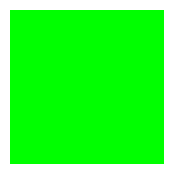

In [3]:
def display_test_passage(condition, test_name):
    color_image = np.zeros((1,1,3))
    if condition: #green if true
        color_index = 1
        test_string = f'Test: {test_name} passed'
    else: #red if false
        color_index = 0
        test_string = f'Test: {test_name} failed'

    color_image[:, :, color_index] = 1
    plt.figure(figsize = (2,2))
    plt.imshow(color_image)
    plt.axis('off')
    print(test_string)
display_test_passage('a' == 'a', 'sample test')

### 1.2 User parameters

In [4]:
user_params = {
    'output_dir'  : './dbtl1_figures_and_results/',
    'protein_map' : './data/Sample name, CRISPRi target gene, Uniprot ID v2.xlsx',
    'double_targets_file': f'./data/CRISPRi_double_targets.csv',
    'triple_targets_file': f'./data/CRISPRi_triple_targets.csv',
    'run_list' : f'./data/sample injection order.xlsx',
    'n_instances_double': 30,
    'n_instances_triple': 30, 
    'max_guide_rnas': 5
}



### 1.3a Download the data

These are the [Experiment Data Depot](https://pubs.acs.org/doi/full/10.1021/acssynbio.7b00204) server, the corresponding username and the slug (address) for the study to be downloaded:

In [5]:
# study_slug_dbtl0 = 'crispri-automation-for-isoprenol-production-in-p-p'
# study_slug_dbtl1 = 'crispri-automation-for-enhanced-isoprenol-producti'
# edd_server   = 'edd.jbei.org'
# username     = 'pckinnunen'

# try:
#     session = eddu.login(edd_server=edd_server, user=username)
# except:
#     print('ERROR! Connection to EDD failed. We will try to load data from disk...')
# else:
#     print('OK! Connection to EDD successful. We will try to load data from EDD...')
    
    
    
# try:
#     df_dbtl0 = eddu.export_study(session, study_slug_dbtl0, edd_server=edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL0 study.')
    
# try:
#     df_dbtl1 = eddu.export_study(session, study_slug_dbtl1, edd_server = edd_server)
# except (NameError, AttributeError, KeyError):
#     print(f'ERROR! Not able to export DBTL1 study.')   

### 1.3b Get isoprenol data locally

In [6]:
df_dbtl0 = pd.read_pickle('./isoprenol_data/dbtl0_isoprenol.pkl')
df_dbtl1 = pd.read_pickle('./isoprenol_data/dbtl1_isoprenol.pkl')

There are lots of data here (particularly the biolector data takes a lot of space):

The only protocol left in the data is GC-FID, corresponding to isoprenol measurements.

In [7]:
df_dbtl0['Protocol'].unique()

array(['GC-FID'], dtype=object)

In [8]:
df_dbtl1['Protocol'].unique()

array(['GC-FID'], dtype=object)

## Data preprocessing

Compare the formats between datasets

In [9]:
df_dbtl0.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
594519,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,177.33700,24.0
594520,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,181.88373,24.0
594521,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,169.40580,24.0


In [10]:
df_dbtl1.head(3)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,188814,CRISPRi automation for enhanced isoprenol prod...,189546,ff8e234f-b5be-4251-8aba-62768f8a9167,PP_0226_PP_0897_PP_5288-R1,DBTL1_P1_001,GC-FID,189738,PP_0226_PP_0897_PP_5288-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,173.9811,24.0
1,188814,CRISPRi automation for enhanced isoprenol prod...,189547,97cf59b2-f9f2-4ce4-9cfb-34bf130ba140,PP_1319_PP_1457_PP_4192-R1,DBTL1_P1_002,GC-FID,189739,PP_1319_PP_1457_PP_4192-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,268.6526,24.0
2,188814,CRISPRi automation for enhanced isoprenol prod...,189548,c94ef30a-a46f-4ae0-9763-544159d054a9,PP_2213_PP_2471_PP_4266-R1,DBTL1_P1_003,GC-FID,189740,PP_2213_PP_2471_PP_4266-R1,cid:12988,3-METHYL-3-BUTEN-1-OL,0,mg/L,182.8489,24.0


### Process individual dataframes

#### break out replicate information

In [11]:
def add_replicate_number(x):
    rep_position = x.find('-R')+2
    return int(x[rep_position:])
df_dbtl0['rep'] = df_dbtl0['Line Name'].apply(add_replicate_number)
df_dbtl1['rep'] = df_dbtl1['Line Name'].apply(add_replicate_number)

add_line_name = lambda x: x.split('-')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['Line Name'].apply(add_line_name)
df_dbtl1['line_name_norep'] = df_dbtl1['Line Name'].apply(add_line_name)

#### Drop plate information from dbtl1 dataframe
David included the plate that each control is in for DBTL1. I don't need that information so dropping it.


In [12]:
filter_control_name = lambda x: 'Control' if 'ontrol' in x else x
df_dbtl1['line_name_norep'] = df_dbtl1['line_name_norep'].apply(filter_control_name)

In [13]:
df_dbtl0['line_name_norep'].unique()

array(['Control', 'PP_0001', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106',
       'PP_0168', 'PP_0225', 'PP_0226', 'PP_0277', 'PP_0338', 'PP_0362',
       'PP_0368', 'PP_0437', 'PP_0528', 'PP_0548', 'PP_0582', 'PP_0597',
       'PP_0654', 'PP_0658', 'PP_0691', 'PP_0751', 'PP_0774', 'PP_0806',
       'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815', 'PP_0897', 'PP_0944',
       'PP_0999', 'PP_1023', 'PP_1031', 'PP_1157', 'PP_1240', 'PP_1251',
       'PP_1317', 'PP_1318', 'PP_1319', 'PP_1394', 'PP_1444', 'PP_1457',
       'PP_1506', 'PP_1607_NT1', 'PP_1607_NT1_xylS_Pm', 'PP_1607_NT2',
       'PP_1607_NT2_xylS_Pm', 'PP_1607_NT3', 'PP_1607_NT3_xylS_Pm',
       'PP_1607_NT4', 'PP_1607_NT4_xylS_Pm', 'PP_1610', 'PP_1620',
       'PP_1664', 'PP_1755', 'PP_1769', 'PP_1770', 'PP_1777', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_2589', 'PP_2925', 'PP_3071', 'PP_3122', 'PP_3123', 'PP_3280',
       'PP_3282', 'PP_3355', 'PP_3365', 'PP_3394', 'PP_3578', 'P

#### add column for non-template information in DBTL0
Some Lines are defined by an extra identifier for non-template information. 

In [14]:
def extract_nt_information(line_name):
    if '_NT' in line_name:
        #do something
        return 'NT'+line_name.split('_NT')[1]
    else: 
        return None

In [15]:
df_dbtl0['nt_string'] = df_dbtl0['line_name_norep'].apply(extract_nt_information)
df_dbtl1['nt_string'] = df_dbtl1['line_name_norep'].apply(extract_nt_information)

Remove NT information from line_name_norep

In [16]:
remove_nt_information = lambda x: x.split('_NT')[0]
df_dbtl0['line_name_norep'] = df_dbtl0['line_name_norep'].apply(remove_nt_information)

### Merge dataframes
At this point, the dataframes have the same columns and formatting, so I can merge them.

First, test that columns match:

Test: Before merging, test that dbtl0 and dbtl1 columns are the same passed


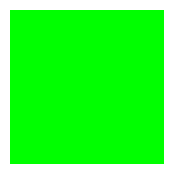

In [17]:
display_test_passage(np.all(np.sort(df_dbtl0.columns) == np.sort(df_dbtl1.columns)), 'Before merging, test that dbtl0 and dbtl1 columns are the same')

Add `cycle` column to each dataframe

In [18]:
df_dbtl0['cycle'] = 0
df_dbtl1['cycle'] = 1

In [19]:
sum(df_dbtl1['line_name_norep'] == 'Control')

12

In [20]:
df_dbtl1['Line Name'].unique()

array(['PP_0226_PP_0897_PP_5288-R1', 'PP_1319_PP_1457_PP_4192-R1',
       'PP_2213_PP_2471_PP_4266-R1', 'PP_3123_PP_4862_PP_5186-R1',
       'PP_2137_PP_4116_PP_4187-R1', 'PP_4189_PP_4550_PP_4862-R1',
       'PP_0813_PP_1769_PP_4191-R1', 'PP_0368_PP_4191_PP_4192-R1',
       'PP_0226_PP_0897_PP_5288-R2', 'PP_1319_PP_1457_PP_4192-R2',
       'PP_2213_PP_2471_PP_4266-R2', 'PP_3123_PP_4862_PP_5186-R2',
       'PP_2137_PP_4116_PP_4187-R2', 'PP_4189_PP_4550_PP_4862-R2',
       'PP_0813_PP_1769_PP_4191-R2', 'PP_0368_PP_4191_PP_4192-R2',
       'PP_0226_PP_0897_PP_5288-R3', 'PP_1319_PP_1457_PP_4192-R3',
       'PP_2213_PP_2471_PP_4266-R3', 'PP_3123_PP_4862_PP_5186-R3',
       'PP_2137_PP_4116_PP_4187-R3', 'PP_4189_PP_4550_PP_4862-R3',
       'PP_0813_PP_1769_PP_4191-R3', 'PP_0368_PP_4191_PP_4192-R3',
       'PP_0751_PP_1620_PP_4678-R1', 'PP_0813_PP_4549_PP_5288-R1',
       'PP_2112_PP_2136_PP_4678-R1', 'PP_0368_PP_0812_PP_0944-R1',
       'PP_0999_PP_3578_PP_5186-R1', 'PP_2137_PP_4011_PP_4120-

In [21]:
df = pd.concat([df_dbtl0, df_dbtl1], axis = 0).reset_index(drop = True)

In [22]:
df['line_name_norep'].unique()

array(['Control', 'PP_0001', 'PP_0103', 'PP_0104', 'PP_0105', 'PP_0106',
       'PP_0168', 'PP_0225', 'PP_0226', 'PP_0277', 'PP_0338', 'PP_0362',
       'PP_0368', 'PP_0437', 'PP_0528', 'PP_0548', 'PP_0582', 'PP_0597',
       'PP_0654', 'PP_0658', 'PP_0691', 'PP_0751', 'PP_0774', 'PP_0806',
       'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815', 'PP_0897', 'PP_0944',
       'PP_0999', 'PP_1023', 'PP_1031', 'PP_1157', 'PP_1240', 'PP_1251',
       'PP_1317', 'PP_1318', 'PP_1319', 'PP_1394', 'PP_1444', 'PP_1457',
       'PP_1506', 'PP_1607', 'PP_1610', 'PP_1620', 'PP_1664', 'PP_1755',
       'PP_1769', 'PP_1770', 'PP_1777', 'PP_2095', 'PP_2112', 'PP_2136',
       'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471', 'PP_2589', 'PP_2925',
       'PP_3071', 'PP_3122', 'PP_3123', 'PP_3280', 'PP_3282', 'PP_3355',
       'PP_3365', 'PP_3394', 'PP_3578', 'PP_3744', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4012', 'PP_4043', 'PP_4116', 'PP_4119', 'PP_4120',
       'PP_4121', 'PP_4122', 'PP_4123', 'PP_4128', 

### Add control field

In [23]:
boolean_control_check = lambda x: 1 if 'ontrol' in x else 0
df['is_control'] = df['line_name_norep'].apply(boolean_control_check).astype(bool)

Test: All measurement types are 3-METHYL-3-BUTEN-1-OL, can replace string with isoprenol passed


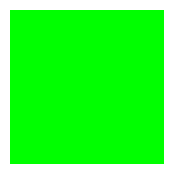

In [24]:
display_test_passage(df['Measurement Type'].unique() == ['3-METHYL-3-BUTEN-1-OL'], 'All measurement types are 3-METHYL-3-BUTEN-1-OL, can replace string with isoprenol')

### Add columns for each guide RNA position

To turn the gRNA strings to features for ART, we create a column for each gRNA position. We also add a column for number of gRNAs.

In [25]:
grna_columns = [f'gRNA_{i}' for i in range(1, user_params['max_guide_rnas']+1)]
grna_columns

['gRNA_1', 'gRNA_2', 'gRNA_3', 'gRNA_4', 'gRNA_5']

In [26]:
for g in grna_columns:
    df[g] = 'None'

Write a function to parse the line name and turn it into a list

In [27]:
def add_sorted_gene_list(line_name_norep):
    if 'Control' in line_name_norep:
        return []
    else:
        split_span = 2
        split_line_name = line_name_norep.split('_')
        return np.sort(['_'.join(split_line_name[i:i+split_span]) for i in range(0, len(split_line_name), split_span)])

In [28]:
df['sorted_gene_list']= df['line_name_norep'].apply(add_sorted_gene_list)
df.tail(5)

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,line_name_norep,nt_string,cycle,is_control,gRNA_1,gRNA_2,gRNA_3,gRNA_4,gRNA_5,sorted_gene_list
592,188814,CRISPRi automation for enhanced isoprenol prod...,189685,9590a255-5d61-4399-819a-3086a800832f,PP_0437_PP_3365-R3,DBTL1_P4_044,GC-FID,189877,PP_0437_PP_3365-R3,cid:12988,...,PP_0437_PP_3365,None,1,False,None,None,None,None,None,"[PP_0437, PP_3365]"
593,188814,CRISPRi automation for enhanced isoprenol prod...,189686,168176ce-340e-4bd4-9df1-5480126c9dba,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,GC-FID,189878,PP_1319_PP_4121_PP_4667-R3,cid:12988,...,PP_1319_PP_4121_PP_4667,None,1,False,None,None,None,None,None,"[PP_1319, PP_4121, PP_4667]"
594,188814,CRISPRi automation for enhanced isoprenol prod...,189687,00bd31cf-e573-47e2-96cf-ee7bb9714c13,PP_0814_PP_4192-R3,DBTL1_P4_046,GC-FID,189879,PP_0814_PP_4192-R3,cid:12988,...,PP_0814_PP_4192,None,1,False,None,None,None,None,None,"[PP_0814, PP_4192]"
595,188814,CRISPRi automation for enhanced isoprenol prod...,189688,1e8313e0-4ed7-498b-95fa-f5738a3d7654,PP_0812_PP_4121-R3,DBTL1_P4_047,GC-FID,189880,PP_0812_PP_4121-R3,cid:12988,...,PP_0812_PP_4121,None,1,False,None,None,None,None,None,"[PP_0812, PP_4121]"
596,188814,CRISPRi automation for enhanced isoprenol prod...,189689,6aa49dec-12a7-4d31-8a08-8b839e950ab3,Control_P4-R3,DBTL1_P4_048,GC-FID,189881,Control_P4-R3,cid:12988,...,Control,None,1,True,None,None,None,None,None,[]


In [29]:
def return_gene_from_genelist(gene_list, position):
    if position>=len(gene_list):
        return None
    else:
        return gene_list[position]

for g_idx, g in enumerate(grna_columns):
    df[g] = df['sorted_gene_list'].apply(lambda x: return_gene_from_genelist(x, g_idx))

Finally, add a column for the number of genes manipulated

In [30]:
count_number_of_grna = lambda x: len(x)
df['number_of_grna'] = df['sorted_gene_list'].apply(len)

### Rename Value
All measurements in the dataframe are isoprenol, so rename the column to be more clear.

In [31]:
df = df.rename(columns={'Value':'isoprenol'})

### Drop extra columns

In [32]:
df.head()

,Study ID,Study Name,Line ID,Replicate Key,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,...,nt_string,cycle,is_control,gRNA_1,gRNA_2,gRNA_3,gRNA_4,gRNA_5,sorted_gene_list,number_of_grna
0,187352,CORRECTED: CRISPRi automation for enhanced iso...,187360,3475b66f-023e-4334-a86d-374b4094f346,Control-R1,BL1A1_NT,GC-FID,188815,Control-R1,cid:12988,...,None,0,True,None,None,None,None,None,[],0
1,187352,CORRECTED: CRISPRi automation for enhanced iso...,187368,0445a7bc-3aaf-401a-a0c4-e77922997140,Control-R2,BL1B1_NT,GC-FID,188823,Control-R2,cid:12988,...,None,0,True,None,None,None,None,None,[],0
2,187352,CORRECTED: CRISPRi automation for enhanced iso...,187376,086e7c52-b5ac-42ca-81d1-e170b23b37fc,Control-R3,BL1C1_NT,GC-FID,188831,Control-R3,cid:12988,...,None,0,True,None,None,None,None,None,[],0
3,187352,CORRECTED: CRISPRi automation for enhanced iso...,187408,8d8b104b-b36a-4c30-b5d9-1449e73fb218,Control-R4,BL2A1_NT,GC-FID,188863,Control-R4,cid:12988,...,None,0,True,None,None,None,None,None,[],0
4,187352,CORRECTED: CRISPRi automation for enhanced iso...,187416,63f68f0d-d4a8-4b64-b1ba-8412da15aecb,Control-R5,BL2B1_NT,GC-FID,188871,Control-R5,cid:12988,...,None,0,True,None,None,None,None,None,[],0


In [33]:
columns_to_keep = ['Line Name', 'Line Description', 'Units', 'isoprenol', 'rep', 'line_name_norep', 'nt_string', 'cycle', 'is_control', 'sorted_gene_list', 'number_of_grna'] + grna_columns
df = df.loc[:,columns_to_keep]
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,gRNA_1,gRNA_2,gRNA_3,gRNA_4,gRNA_5
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,None,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,None,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,None,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,None,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",2,PP_0437,PP_3365,None,None,None
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",3,PP_1319,PP_4121,PP_4667,None,None
594,PP_0814_PP_4192-R3,DBTL1_P4_046,mg/L,328.09770,3,PP_0814_PP_4192,None,1,False,"[PP_0814, PP_4192]",2,PP_0814,PP_4192,None,None,None
595,PP_0812_PP_4121-R3,DBTL1_P4_047,mg/L,294.92530,3,PP_0812_PP_4121,None,1,False,"[PP_0812, PP_4121]",2,PP_0812,PP_4121,None,None,None


## Initial Plots of data

### How does number of gRNA affect titer

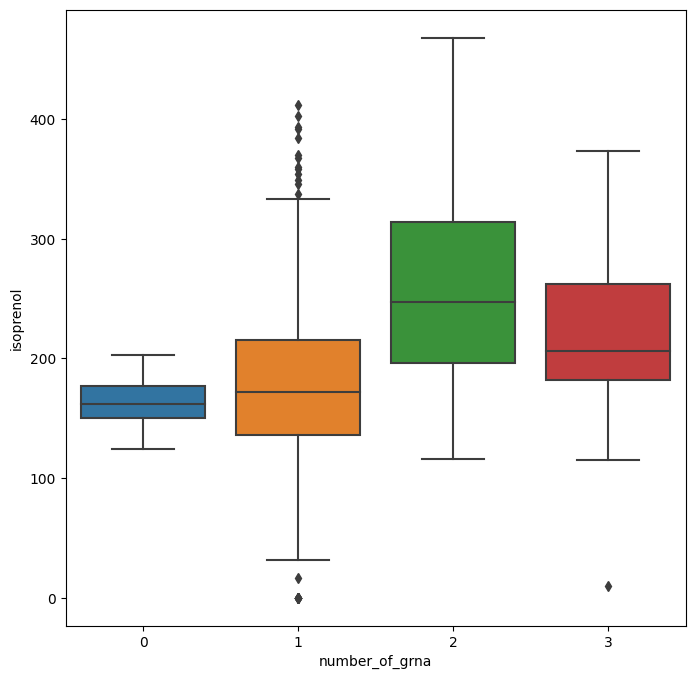

In [34]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df, x = 'number_of_grna', y = 'isoprenol', ax = ax)
fig.savefig(user_params['output_dir'] + 'grna_vs_titer_boxplot.png',  bbox_inches='tight')

### Compare control runs

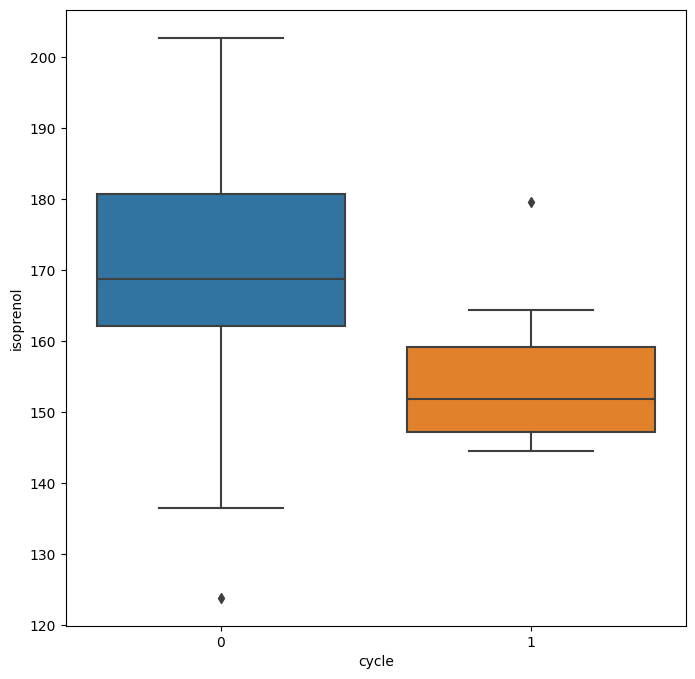

In [35]:
fig, ax = plt.subplots(figsize = (8,8))
sns.boxplot(data = df[df['is_control']], x = 'cycle', y = 'isoprenol')
fig.savefig(user_params['output_dir'] + 'cycle_control_comparison_boxplot.png',  bbox_inches='tight')

Can check how similar the two sets of controls are. TODO: Talk about interpretation of this.

In [36]:
from scipy.stats import ttest_ind
ttest_ind(a = df[((df['is_control'] == True) & (df['cycle'] == 0))]['isoprenol'],
          b = df[((df['is_control'] == True) & (df['cycle'] == 1))]['isoprenol'])

TtestResult(statistic=2.463242240240987, pvalue=0.020178632782176124, df=28.0)

### Plot all strains

In [37]:
# fig, ax = plt.subplots(figsize = (5,40))
# sns.barplot(data = df.sort_values('isoprenol', ascending=True), y = 'line_name_norep', x = 'isoprenol', hue = 'cycle', ax = ax, dodge = False, width = 0.9, palette = 'plasma')
# fig.savefig(user_params['output_dir'] + 'mean_bargraph_by_strain.png',  bbox_inches='tight')

## Prepare data for ART 
To run ART on the data, we need to transform the gene list for each strain into a binary vector (0/1 at all positions), then transform the data into an ART-formatted dataframe, then configure ART and run it.

### Add gene columns to ART

In [38]:
all_perturbed_genes = df[((df['cycle'] == 0) & (df['is_control'] == False))]['line_name_norep'].unique()
all_perturbed_genes
print(f'There are N = {len(all_perturbed_genes)} from DBTL0. \nAll perturbed genes from DBTL0: \n{all_perturbed_genes}')

There are N = 121 from DBTL0. 
All perturbed genes from DBTL0: 
['PP_0001' 'PP_0103' 'PP_0104' 'PP_0105' 'PP_0106' 'PP_0168' 'PP_0225'
 'PP_0226' 'PP_0277' 'PP_0338' 'PP_0362' 'PP_0368' 'PP_0437' 'PP_0528'
 'PP_0548' 'PP_0582' 'PP_0597' 'PP_0654' 'PP_0658' 'PP_0691' 'PP_0751'
 'PP_0774' 'PP_0806' 'PP_0812' 'PP_0813' 'PP_0814' 'PP_0815' 'PP_0897'
 'PP_0944' 'PP_0999' 'PP_1023' 'PP_1031' 'PP_1157' 'PP_1240' 'PP_1251'
 'PP_1317' 'PP_1318' 'PP_1319' 'PP_1394' 'PP_1444' 'PP_1457' 'PP_1506'
 'PP_1607' 'PP_1610' 'PP_1620' 'PP_1664' 'PP_1755' 'PP_1769' 'PP_1770'
 'PP_1777' 'PP_2095' 'PP_2112' 'PP_2136' 'PP_2137' 'PP_2213' 'PP_2339'
 'PP_2471' 'PP_2589' 'PP_2925' 'PP_3071' 'PP_3122' 'PP_3123' 'PP_3280'
 'PP_3282' 'PP_3355' 'PP_3365' 'PP_3394' 'PP_3578' 'PP_3744' 'PP_3754'
 'PP_3755' 'PP_4011' 'PP_4012' 'PP_4043' 'PP_4116' 'PP_4119' 'PP_4120'
 'PP_4121' 'PP_4122' 'PP_4123' 'PP_4128' 'PP_4130' 'PP_4159' 'PP_4160'
 'PP_4161' 'PP_4174' 'PP_4175' 'PP_4185' 'PP_4186' 'PP_4187' 'PP_4188'
 'PP_4189' 'P

Add gene columns to dataframe.

In [39]:
df

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,number_of_grna,gRNA_1,gRNA_2,gRNA_3,gRNA_4,gRNA_5
0,Control-R1,BL1A1_NT,mg/L,177.33700,1,Control,None,0,True,[],0,None,None,None,None,None
1,Control-R2,BL1B1_NT,mg/L,181.88373,2,Control,None,0,True,[],0,None,None,None,None,None
2,Control-R3,BL1C1_NT,mg/L,169.40580,3,Control,None,0,True,[],0,None,None,None,None,None
3,Control-R4,BL2A1_NT,mg/L,161.67620,4,Control,None,0,True,[],0,None,None,None,None,None
4,Control-R5,BL2B1_NT,mg/L,136.42987,5,Control,None,0,True,[],0,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",2,PP_0437,PP_3365,None,None,None
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",3,PP_1319,PP_4121,PP_4667,None,None
594,PP_0814_PP_4192-R3,DBTL1_P4_046,mg/L,328.09770,3,PP_0814_PP_4192,None,1,False,"[PP_0814, PP_4192]",2,PP_0814,PP_4192,None,None,None
595,PP_0812_PP_4121-R3,DBTL1_P4_047,mg/L,294.92530,3,PP_0812_PP_4121,None,1,False,"[PP_0812, PP_4121]",2,PP_0812,PP_4121,None,None,None


TODO: Check for a better way to do this (add many empty columns to dataframe) - currently getting a bunch of warnings. 
TODO: Unsure whether to keep this warning or not - see discussion here: https://stackoverflow.com/questions/68292862/performancewarning-dataframe-is-highly-fragmented-this-is-usually-the-result-o

In [40]:
# mydf = mydf.reindex(columns = mydf.columns.tolist() + ['newcol1','newcol2'])
# df = df.reindex(columns = df.columns.tolist() + all_perturbed_genes.tolist())

In [41]:
# from warnings import simplefilter 
# simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
# df[all_perturbed_genes] = 0

In [42]:
# for i in all_perturbed_genes:
    # df[i] = 0

### Add and fill in columns for genes

In [43]:
from warnings import simplefilter 
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
def check_if_gene_in_list(gene_list, gene):
    if gene in gene_list:
        return 1
    else:
        return 0
    
for perturbed_gene in all_perturbed_genes:
    df[perturbed_gene] = df['sorted_gene_list'].apply(lambda x: check_if_gene_in_list(x, perturbed_gene)).astype(int)


#### Sanity checks for converting gene list to feature

Each 'PP_XXXX' column is a binary indicator of whether that gene was perturbed - so the sum of all PP_ columns should equal the number of gRNAs for each line:

Test: Do number of binary features match the number_of_grna column? passed


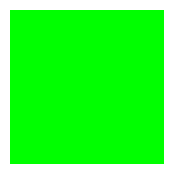

In [44]:
sum_binary_gene_columns = df.loc[:, all_perturbed_genes].sum(axis = 1)
display_test_passage(np.all(sum_binary_gene_columns.values == df['number_of_grna'].values), 'Do number of binary features match the number_of_grna column?')

No PP_XXXX columns should be empty, because they were created as a list of all genes that were perturbed.

Test: All genes are perturbed in at least 1 line with 3 reps. passed


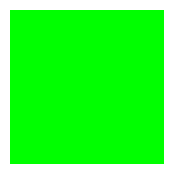

In [45]:
sum_binary_gene_rows = df.loc[:, all_perturbed_genes].sum(axis = 0)
display_test_passage(min(sum_binary_gene_rows)>=3, 'All genes are perturbed in at least 1 line with 3 reps.')

## Identify genes to pass to ART
ART will not be able to learn very much from genes that only appear by themselves in DBTL0. Thus, we will identify only those genes that are present in DBTL1 (in double or triple gRNA lines), and only use those genes with ART.

In [46]:
cycle1_perturbed_genes = np.sort(np.unique(np.concatenate(df.loc[df['cycle'] == 1, 'sorted_gene_list'].values, axis = 0)))
cycle1_perturbed_genes

array(['PP_0226', 'PP_0368', 'PP_0437', 'PP_0528', 'PP_0597', 'PP_0658',
       'PP_0751', 'PP_0774', 'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815',
       'PP_0897', 'PP_0944', 'PP_0999', 'PP_1317', 'PP_1319', 'PP_1444',
       'PP_1457', 'PP_1506', 'PP_1607', 'PP_1620', 'PP_1769', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_3071', 'PP_3123', 'PP_3365', 'PP_3578', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4116', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4186',
       'PP_4187', 'PP_4188', 'PP_4189', 'PP_4191', 'PP_4192', 'PP_4266',
       'PP_4549', 'PP_4550', 'PP_4651', 'PP_4667', 'PP_4678', 'PP_4679',
       'PP_4862', 'PP_5186', 'PP_5288'], dtype='<U32')

In [47]:
check_for_cycle1_gene = lambda gene_list: 1 if np.any([single_gene in cycle1_perturbed_genes for single_gene in gene_list]) else 0
df['has_cycle1_gene'] = df['sorted_gene_list'].apply(check_for_cycle1_gene).astype(bool)
df[df['has_cycle1_gene']]

,Line Name,Line Description,Units,isoprenol,rep,line_name_norep,nt_string,cycle,is_control,sorted_gene_list,...,PP_5128,PP_5186,PP_5203,PP_5288,PP_5335,PP_5416,PP_5417,PP_5419,PP_5420,has_cycle1_gene
39,PP_0226-R1,BL8D2_IY2207,mg/L,142.40009,1,PP_0226,None,0,False,[PP_0226],...,0,0,0,0,0,0,0,0,0,True
40,PP_0226-R2,BL8E2_IY2207,mg/L,139.02969,2,PP_0226,None,0,False,[PP_0226],...,0,0,0,0,0,0,0,0,0,True
41,PP_0226-R3,BL8F2_IY2207,mg/L,137.47671,3,PP_0226,None,0,False,[PP_0226],...,0,0,0,0,0,0,0,0,0,True
51,PP_0368-R1,BL1A4_IY1588,mg/L,227.04760,1,PP_0368,None,0,False,[PP_0368],...,0,0,0,0,0,0,0,0,0,True
52,PP_0368-R2,BL1B4_IY1588,mg/L,246.32420,2,PP_0368,None,0,False,[PP_0368],...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,PP_0999_PP_4679-R3,DBTL1_P4_043,mg/L,196.09140,3,PP_0999_PP_4679,None,1,False,"[PP_0999, PP_4679]",...,0,0,0,0,0,0,0,0,0,True
592,PP_0437_PP_3365-R3,DBTL1_P4_044,mg/L,247.03410,3,PP_0437_PP_3365,None,1,False,"[PP_0437, PP_3365]",...,0,0,0,0,0,0,0,0,0,True
593,PP_1319_PP_4121_PP_4667-R3,DBTL1_P4_045,mg/L,208.59250,3,PP_1319_PP_4121_PP_4667,None,1,False,"[PP_1319, PP_4121, PP_4667]",...,0,0,0,0,0,0,0,0,0,True
594,PP_0814_PP_4192-R3,DBTL1_P4_046,mg/L,328.09770,3,PP_0814_PP_4192,None,1,False,"[PP_0814, PP_4192]",...,0,0,0,0,0,0,0,0,0,True


### melt dataframe to format for ART
ART runs on a dataframe with three columns: 

- Line Name: A unique identifier for each line with any -RX denoting a replicate measurement
- Variable: the name of the variable, ex: 'PP_0461' (a binary variable) or 'isoprenol' (a continuous variable)
- Value: The numeric value of the variable. 

In [48]:
df_art = pd.melt(df[df['has_cycle1_gene']], id_vars = 'Line Name', var_name = 'Type', value_vars = cycle1_perturbed_genes.tolist() + ['isoprenol'], value_name='0.0')

In [49]:
df_art

,Line Name,Type,0.0
0,PP_0226-R1,PP_0226,1.0000
1,PP_0226-R2,PP_0226,1.0000
2,PP_0226-R3,PP_0226,1.0000
3,PP_0368-R1,PP_0226,0.0000
4,PP_0368-R2,PP_0226,0.0000
...,...,...,...
21571,PP_0999_PP_4679-R3,isoprenol,196.0914
21572,PP_0437_PP_3365-R3,isoprenol,247.0341
21573,PP_1319_PP_4121_PP_4667-R3,isoprenol,208.5925
21574,PP_0814_PP_4192-R3,isoprenol,328.0977


dataframe melting sanity check - the number of rows in the new dataframe should be:

(N unique lines) * (Number of perturbed proteins + 1)

where the +1 comes from the Value column.

Test: Does melted dataframe have correct number of rows? passed


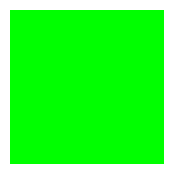

In [50]:
display_test_passage(len(df_art) == (len(df.loc[df['has_cycle1_gene'],'Line Name'].unique()) * (len(cycle1_perturbed_genes) + 1)), 'Does melted dataframe have correct number of rows?')
assert len(df_art) == (len(df.loc[df['has_cycle1_gene'],'Line Name'].unique()) * (len(cycle1_perturbed_genes) + 1))

### Set up ART parameters
ART expects a dictionary of parameters that we need to set up.

#### Set up ART bounds
ART bounds are defined as a dataframe with columns: ['Variable', 'Min', 'Max']

In [51]:
art_bounds_dict = {'Variable': cycle1_perturbed_genes,
                   'Min': int(0),
                   'Max': int(1)
                  }
art_bounds = pd.DataFrame(art_bounds_dict)
art_bounds.head(3)

,Variable,Min,Max
0,PP_0226,0,1
1,PP_0368,0,1
2,PP_0437,0,1


In [52]:
art_params = {'input_vars': cycle1_perturbed_genes.tolist(),
              'input_var_type': 'categorical', #Only binary values will be chose by ART
              'bounds': art_bounds,
              'scale_input_vars': False,
              'response_vars': ['isoprenol'],
              'build_model': True,
              'cross_val': False,
              'cross_val_partitions': 5,
              'recommend': False, #We will use the trained model to evaluate recommendations outside of ARTs API.
              'objective': 'maximize',
              'threshold': 0.2,
              'num_recommendations': 200,
              'rel_rec_distance': 0.1,
              'alpha': 0.6,
              'output_dir': './dbtl1_art_results_cycle1genes',
              'verbose': 1,
              'testing': False,
              'initial_cycle': False,
              'last_dashes_denote_replicates': True}

## Run ART
Currently, running art with high verbosity. Cross-validation is turned off to save time.

ART identified 121 unique designs in the training data. 
Correctly communicating your designs is critical to building ART's model and to cross-validation.  We strongly suggest verifying ART's interpretation of your designs by inspecting the preprocessed DataFrame.  For example, if your ART instance is named `engine`, run `engine.df["Design"]`.  See documentation for `last_dashes_denote_replicates` for a description of how ART detects designs.
Building models…
Fitting L0 models…
Building TPOT models…


Version 0.11.7 of tpot is outdated. Version 0.12.1 was released Tuesday August 15, 2023.


Best pipeline: ExtraTreesRegressor(ZeroCount(input_matrix), bootstrap=False, max_features=0.45, min_samples_leaf=4, min_samples_split=8, n_estimators=100)
Done fitting L0 models in 66.31 s
Building ensemble model (4 sampling jobs)…


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, omegas]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 43 seconds.


Done building ensemble model in 51.73 s


,MAE,MRAE(%),StdAE,MSE,$R^2$
Name,,,,,
Neural Regressor,11.739220,8.772059,14.810306,357.154459,0.932534
Random Forest Regressor,12.033132,9.072881,14.873508,366.017529,0.930860
Support Vector Regressor,54.057482,30.742818,46.638537,5097.364406,0.037118
Kernel Ridge Regressor,28.655461,15.915522,16.987584,1109.713436,0.790377
K-NN Regressor,29.534984,18.754149,25.757264,1535.751938,0.709900
Gaussian Process Regressor,11.974198,8.938707,14.799134,362.395797,0.931544
Gradient Boosting Regressor,24.330067,16.585105,20.893253,1028.480150,0.805722
TPOT Regressor,28.895650,18.152157,26.727727,1549.329940,0.707335
Ensemble Model,21.350694,14.347508,19.141691,822.256478,0.844677


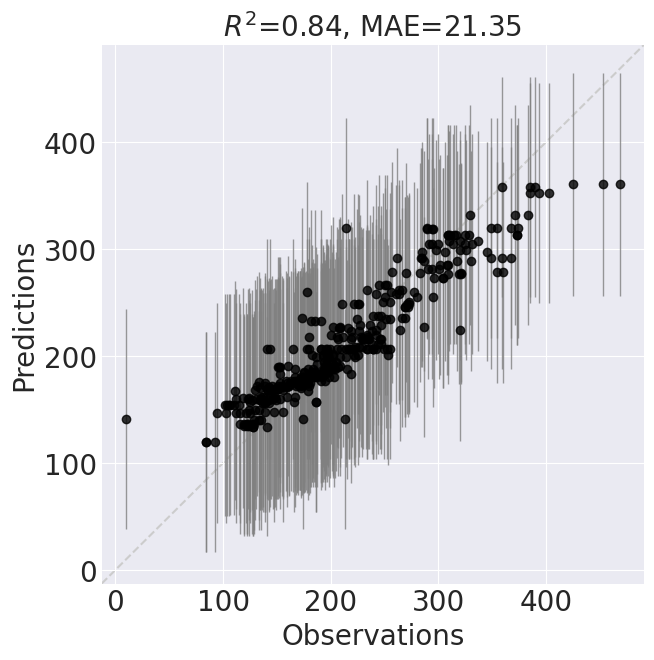

Done building models in 136.60 s


In [53]:
art = RecommendationEngine(df = df_art, **art_params)

## Use trained model to evaluate designs
ART's built in categorical optimizer and recommender evaluates all possible combinations of input variables, which here would be $2^{57}$ different combinations. We can only combine up to 5 gRNAs, so we only have possible combinations.

First, import some lower-level functions from ART.

In [54]:
from art.core import CategoricalOptimizer
import itertools

Use itertools to make all combinations with length 5 or shorter

In [55]:
total_gRNA = len(cycle1_perturbed_genes)
grna_indices = np.arange(total_gRNA)
max_number_grna = 5
all_possible_designs = []
for l in np.arange(0,max_number_grna+1):
    all_possible_designs.append(list(itertools.combinations(grna_indices,l)))

Flatten the list of lists:

In [56]:
all_possible_designs = [item for sublist in all_possible_designs for item in sublist]
print(f'There are N={len(all_possible_designs)} total combinations')

There are N=4613030 total combinations


Convert into a binary array which can be passed to ART

In [57]:
binary_designs = np.zeros((len(all_possible_designs), total_gRNA)).astype(int)
for i, c in enumerate(all_possible_designs):
    binary_designs[i,c] = 1

print(f"Number of times each gene shows up in designs: {np.unique(np.sum(binary_designs, axis = 0))}")
print(f"Number of nonzero entries in designs: {np.unique(np.sum(binary_designs, axis = 1))}")
print(f"Shape of binary designs: {binary_designs.shape}")

Number of times each gene shows up in designs: [396607]
Number of nonzero entries in designs: [0 1 2 3 4 5]
Shape of binary designs: (4613030, 57)


Sanity checks for generating combinations:
- All genes should show up the same number of times.
- The sum of each combination should be between 0 and 5

In [58]:
assert(len(np.unique(np.sum(binary_designs, axis = 0))) == 1), 'Error generating designs'
# assert(np.all(np.sort(np.unique(np.sum(binary_designs, axis = 1))) == np.array([0,1,2,3,4,5]))), 'Error generating designs'

## Pass possible designs to ART
Use: https://github.com/sorpet/Zhang_and_Petersen_et_al_2019/blob/master/ZP_et_al.ipynb cells around 126

In [59]:
# pp_mean, pp_std = art.post_pred_stats(binary_designs)

In [60]:
# art.post_pred_stats(binary_designs[:,:])

In [61]:
pp_mean, pp_std = [np.zeros((binary_designs.shape[0],1)), np.zeros((binary_designs.shape[0],1))]
from tqdm import tqdm
for idx, design in enumerate(tqdm(binary_designs)):
    m,s = art.post_pred_stats(design)
    pp_mean[idx] = m
    pp_std[idx] = s

100%|██████████| 4613030/4613030 [3:46:07<00:00, 340.02it/s]  


In [62]:
cycle1_perturbed_genes

array(['PP_0226', 'PP_0368', 'PP_0437', 'PP_0528', 'PP_0597', 'PP_0658',
       'PP_0751', 'PP_0774', 'PP_0812', 'PP_0813', 'PP_0814', 'PP_0815',
       'PP_0897', 'PP_0944', 'PP_0999', 'PP_1317', 'PP_1319', 'PP_1444',
       'PP_1457', 'PP_1506', 'PP_1607', 'PP_1620', 'PP_1769', 'PP_2095',
       'PP_2112', 'PP_2136', 'PP_2137', 'PP_2213', 'PP_2339', 'PP_2471',
       'PP_3071', 'PP_3123', 'PP_3365', 'PP_3578', 'PP_3754', 'PP_3755',
       'PP_4011', 'PP_4116', 'PP_4120', 'PP_4121', 'PP_4122', 'PP_4186',
       'PP_4187', 'PP_4188', 'PP_4189', 'PP_4191', 'PP_4192', 'PP_4266',
       'PP_4549', 'PP_4550', 'PP_4651', 'PP_4667', 'PP_4678', 'PP_4679',
       'PP_4862', 'PP_5186', 'PP_5288'], dtype='<U32')

In [63]:
rec_df = pd.DataFrame(columns = list(cycle1_perturbed_genes) + ['pp_mean', 'pp_std'],
                     data = np.hstack([binary_designs, pp_mean, pp_std])) 

In [64]:
rec_df

,PP_0226,PP_0368,PP_0437,PP_0528,PP_0597,PP_0658,PP_0751,PP_0774,PP_0812,PP_0813,...,PP_4550,PP_4651,PP_4667,PP_4678,PP_4679,PP_4862,PP_5186,PP_5288,pp_mean,pp_std
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,177.074370,52.465324
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156.340764,52.332249
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,229.272903,52.341082
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,219.961667,52.292003
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,352.652013,52.602373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,191.251884,52.314489
4613026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,188.586310,52.317876
4613027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,179.543860,52.357746
4613028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,186.171812,52.302952


In [65]:
rec_df.to_pickle(user_params['output_dir'] + 'rec_df.pkl')